In [1]:
!nvidia-smi

Wed Jul  5 05:06:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PyKomoran 형태소분석기 설치

In [2]:
!pip install PyKomoran

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


# 실습 자료 다운로드

In [3]:
!git clone https://github.com/bg-choi/NER.git

Cloning into 'NER'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 39 (delta 18), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (39/39), 10.06 MiB | 4.58 MiB/s, done.


# 디바이스 확인

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("DEVICE: {} || # GPU: {}".format(device, n_gpu))

DEVICE: cuda || # GPU: 1


# 시드 세팅

In [5]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

# 데이터 로딩

## 데이터 로딩 함수 정의

In [6]:
import os
import json

def load_json(file_dir, file_name):
    with open(os.path.join(file_dir, file_name), 'r') as fin:
        return json.load(fin)

## 데이터 로딩

In [7]:
train_raw = load_json('./NER/', 'train.json')
valid_raw = load_json('./NER/', 'valid.json')
test_raw = load_json('./NER/', 'test.json')

print("The number of train data: {}".format(len(train_raw)))
print("The number of dev data: {}".format(len(valid_raw)))
print("The number of test data: {}".format(len(test_raw)))

The number of train data: 6000
The number of dev data: 2000
The number of test data: 2000


# 데이터 타입 및 구조 확인

In [8]:
"""
로딩한 데이터의 타입과 구조를 확인하시오.
"""
print("Raw type")
print(type(train_raw))

Raw type
<class 'list'>


In [9]:
print("Data type")
print(type(train_raw[1]))

Data type
<class 'dict'>


In [10]:
for k, v in train_raw[1].items():
    print(k, ':', v)

text : 장병의 이모이자 어머니이기도 한 김씨는 사단 모범식당 선발에 평가관으로도 활약하고 있다.
ne : [{'id': 1, 'form': '장병', 'label': 'CV', 'begin': 0, 'end': 2}, {'id': 2, 'form': '이모', 'label': 'CV', 'begin': 4, 'end': 6}, {'id': 3, 'form': '어머니', 'label': 'CV', 'begin': 9, 'end': 12}, {'id': 4, 'form': '김', 'label': 'PS', 'begin': 18, 'end': 19}, {'id': 5, 'form': '평가관', 'label': 'CV', 'begin': 34, 'end': 37}]
tokens : [{'id': 0, 'token': '장병/NNG', 'label': 'B-CV'}, {'id': 1, 'token': '의/JKG', 'label': 'O'}, {'id': 2, 'token': '이모/NNP', 'label': 'B-CV'}, {'id': 3, 'token': '이자/NNP', 'label': 'O'}, {'id': 4, 'token': '어머니/NNG', 'label': 'B-CV'}, {'id': 5, 'token': '이/VCP', 'label': 'O'}, {'id': 6, 'token': '기/ETN', 'label': 'O'}, {'id': 7, 'token': '도/JX', 'label': 'O'}, {'id': 8, 'token': '한/MM', 'label': 'O'}, {'id': 9, 'token': '김/NNP', 'label': 'B-PS'}, {'id': 10, 'token': '씨/NNB', 'label': 'O'}, {'id': 11, 'token': '는/JX', 'label': 'O'}, {'id': 12, 'token': '사단/NNP', 'label': 'O'}, {'id': 13, 'token': '모범/NNG', 'lab

# PyKomoran을 이용한 형태소 분석

In [11]:
from PyKomoran import Komoran

pos_tagger = Komoran('EXP')
pos_tagged_text = pos_tagger.get_list(train_raw[1]['text'])
print(pos_tagged_text)
for token in pos_tagged_text:
    morpheme, pos = str(token).split("/")
    print("{}/\t{}".format(morpheme, pos))

[장병/NNG, 의/JKG, 이모/NNG, 이/VCP, 자/EC, 어머니/NNG, 이/VCP, 기/ETN, 도/JX, 한/MM, 김/NNP, 씨/NNB, 는/JX, 사단/NNG, 모범/NNG, 식당/NNG, 선발/NNG, 에/JKB, 평가관/NNG, 으로/JKB, 도/JX, 활약/NNG, 하/XSV, 고/EC, 있/VX, 다/EF, ./SF]
장병/	NNG
의/	JKG
이모/	NNG
이/	VCP
자/	EC
어머니/	NNG
이/	VCP
기/	ETN
도/	JX
한/	MM
김/	NNP
씨/	NNB
는/	JX
사단/	NNG
모범/	NNG
식당/	NNG
선발/	NNG
에/	JKB
평가관/	NNG
으로/	JKB
도/	JX
활약/	NNG
하/	XSV
고/	EC
있/	VX
다/	EF
./	SF


# 실습 - 문장을 입력하고 komoran 함수를 사용해 형태소 분석 해보기

In [13]:
""" [실습] 원하는 문장을 Komoran을 이용해 형태소 분석하고 출력 해보세요 """
text = "무궁화꽃이 피었습니다"

pos_tagged_text = pos_tagger.get_list(text)
print(pos_tagged_text)
for token in pos_tagged_text:
    morpheme, pos = str(token).split("/")
    print("{}/\t{}".format(morpheme, pos))

[무궁화꽃/NNG, 이/JKS, 피/VV, 었/EP, 습니다/EF]
무궁화꽃/	NNG
이/	JKS
피/	VV
었/	EP
습니다/	EF


# 데이터 정형화 함수 정의

In [14]:
def formalize_inputs(dataset):
    x_inputs = list()
    y_inputs = list()

    """
    하나의 컨텍스트를 토큰화된 단위로 리스트에 저장한 후,
    모든 컨텍스트를 x_inputs에 저장하시오.

    각 토큰에 상응하는 label을 리스트에 저장한 후,
    모든 컨텍스트에 대한 label들을 y_inputs에 저장하시오.
    """

    for data in dataset:
        x_temp = []
        y_temp = []

        for d in data['tokens']:
            x_temp.append(d['token'])
            y_temp.append(d['label'])

        x_inputs.append(x_temp)
        y_inputs.append(y_temp)


    return x_inputs, y_inputs

# 데이터 정형화

In [15]:
x_train, y_train = formalize_inputs(train_raw)
x_valid, y_valid = formalize_inputs(valid_raw)

for x, y in zip(x_train[1], y_train[1]):
    print("{} : {}".format(x, y))

장병/NNG : B-CV
의/JKG : O
이모/NNP : B-CV
이자/NNP : O
어머니/NNG : B-CV
이/VCP : O
기/ETN : O
도/JX : O
한/MM : O
김/NNP : B-PS
씨/NNB : O
는/JX : O
사단/NNP : O
모범/NNG : O
식당/NNP : O
선발/NNG : O
에/JKB : O
평가/NNG : B-CV
관/NNG : I-CV
으로/JKB : O
도/JX : O
활약/NNG : O
하/XSV : O
고/EC : O
있/VX : O
다/EF : O
./SF : O


# 단어 집합, 단어 인덱서, 레이블 집합 구축

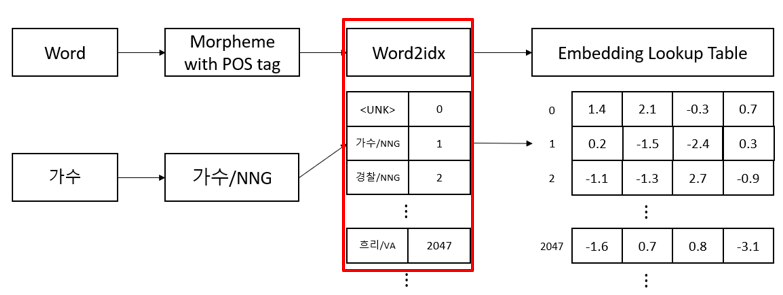

In [16]:
token_set = set()
token2idx = dict()
label_set = set()
n_tokens = 0
n_labels = 0
max_seq_length = 0

"""
단어 집합 (token_set), token2idx, 레이블 집합(label_set), 최장 시퀀스 길이(max_seq_length)를 구축하시오.
"""

for data in (x_train + x_valid):
    if len(data) > max_seq_length:
        max_seq_length = len(data)

    token_set.update(data)

token2idx = {
    '<pad>': 0,
    '<unk>': 1
}

for idx, token in enumerate(sorted(token_set)):
    token2idx[token] = idx + 2

for label in (y_train + y_valid):
    label_set.update(label)

n_tokens = len(token2idx)
n_labels = len(label_set)

print("The number of tokens: {}".format(n_tokens))
print("The number of labels: {}".format(n_labels))
print("Max sequence length: {}".format(max_seq_length))

The number of tokens: 19479
The number of labels: 31
Max sequence length: 149


# token들을 index로 변환하는 함수

In [17]:
def convert_token_to_idx(data, token2idx, max_seq_length):
    return_data = list()
    for d in data:
        temp = list()
        for token in d:
            if token in token2idx.keys():
                temp.append(token2idx[token])
            else:
                temp.append(token2idx['<unk>'])

        if len(temp) >= max_seq_length:
            temp = temp[:max_seq_length]
        else:
            padding = [token2idx['<pad>']] * (max_seq_length - len(temp))
            temp += padding

        return_data.append(temp)

    return return_data

# token들을 index로 변환

In [18]:
x_train_idx = convert_token_to_idx(x_train, token2idx, max_seq_length)
x_valid_idx = convert_token_to_idx(x_valid, token2idx, max_seq_length)

for token, idx in zip(x_train[1], x_train_idx[1]):
    print("{}: {}".format(token, idx))

장병/NNG: 14431
의/JKG: 13385
이모/NNP: 13563
이자/NNP: 13718
어머니/NNG: 11650
이/VCP: 13467
기/ETN: 3645
도/JX: 5408
한/MM: 18400
김/NNP: 3847
씨/NNB: 11053
는/JX: 4762
사단/NNP: 8807
모범/NNG: 6825
식당/NNP: 10700
선발/NNG: 9522
에/JKB: 11799
평가/NNG: 17911
관/NNG: 2873
으로/JKB: 13291
도/JX: 5408
활약/NNG: 19209
하/XSV: 18267
고/EC: 2458
있/VX: 14148
다/EF: 4826
./SF: 27


# Label들을 index로 변환하는 함수

In [20]:
def convert_label_to_idx(data, label2idx, max_seq_length):
    return_data = list()
    for labels in data:
        temp = list()

        for label in labels:
            temp.append(label2idx[label])

        if len(temp) >= max_seq_length:
            temp = temp[:max_seq_length]
        else:
            padding = [-100] * (max_seq_length - len(temp))
            temp += padding

        return_data.append(temp)

    return return_data

# Label들을 index로 변환

In [21]:
label2idx = dict()
idx2label = dict()
label_set = sorted(list(label_set))
for idx, label in enumerate(label_set):
    label2idx[label] = idx
    idx2label[idx] = label

for k, v in label2idx.items():
    print("{}: {}".format(k, v))

y_train_idx = convert_label_to_idx(y_train, label2idx, max_seq_length)
y_valid_idx = convert_label_to_idx(y_valid, label2idx, max_seq_length)

print()

for token, t_idx, label, l_idx in zip(x_train[1], x_train_idx[1], y_train[1], y_train_idx[1]):
    print("{}: {}\t\t//\t{}: {}".format(token, label,  t_idx, l_idx))

B-AF: 0
B-AM: 1
B-CV: 2
B-DT: 3
B-EV: 4
B-FD: 5
B-LC: 6
B-MT: 7
B-OG: 8
B-PS: 9
B-PT: 10
B-QT: 11
B-TI: 12
B-TM: 13
B-TR: 14
I-AF: 15
I-AM: 16
I-CV: 17
I-DT: 18
I-EV: 19
I-FD: 20
I-LC: 21
I-MT: 22
I-OG: 23
I-PS: 24
I-PT: 25
I-QT: 26
I-TI: 27
I-TM: 28
I-TR: 29
O: 30

장병/NNG: B-CV		//	14431: 2
의/JKG: O		//	13385: 30
이모/NNP: B-CV		//	13563: 2
이자/NNP: O		//	13718: 30
어머니/NNG: B-CV		//	11650: 2
이/VCP: O		//	13467: 30
기/ETN: O		//	3645: 30
도/JX: O		//	5408: 30
한/MM: O		//	18400: 30
김/NNP: B-PS		//	3847: 9
씨/NNB: O		//	11053: 30
는/JX: O		//	4762: 30
사단/NNP: O		//	8807: 30
모범/NNG: O		//	6825: 30
식당/NNP: O		//	10700: 30
선발/NNG: O		//	9522: 30
에/JKB: O		//	11799: 30
평가/NNG: B-CV		//	17911: 2
관/NNG: I-CV		//	2873: 17
으로/JKB: O		//	13291: 30
도/JX: O		//	5408: 30
활약/NNG: O		//	19209: 30
하/XSV: O		//	18267: 30
고/EC: O		//	2458: 30
있/VX: O		//	14148: 30
다/EF: O		//	4826: 30
./SF: O		//	27: 30


# 데이터들을 Tensor로 변환

In [27]:
from torch.utils.data import TensorDataset, DataLoader

"""
위에서 구축한 학습 데이터와 검증 데이터를 TensorDataset으로 구축하시오.
"""

x_train_tensor = torch.tensor(x_train_idx, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)

x_valid_tensor = torch.tensor(x_valid_idx, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid_idx, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)

# 실습 - NER을 위한 LSTM 모델 정의

## 순환 신경망 모델 구조

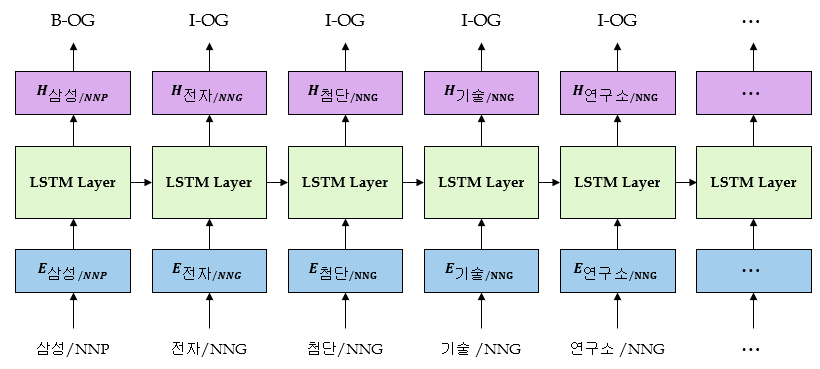

> nn.LSTM()

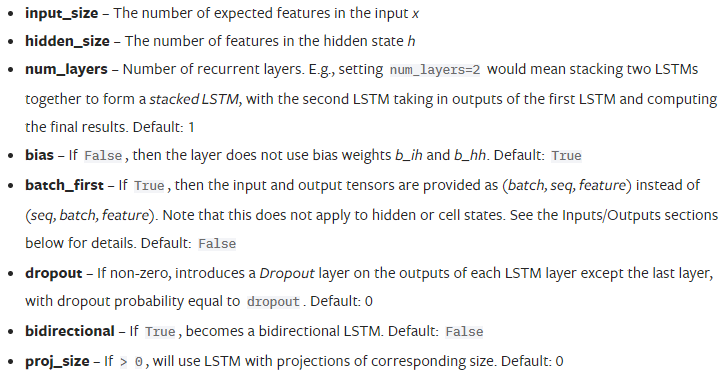

image.png

image.png

In [28]:
import torch.nn as nn

class BasicLSTMForNER(nn.Module):
    def __init__(self, n_tokens, embedding_dim, max_seq_length, n_labels):
        super(BasicLSTMForNER, self).__init__()
        """
        nn.Embedding()
        nn.LSTM()
        nn.Linear()
        을 사용하시오.
        """

        self.embedding = nn.Embedding(n_tokens, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.out = nn.Linear(embedding_dim, n_labels)


    def forward(self, x_train):
        out = None
        """
        forward 함수를 구축하시오.
        """
        # x_train shape: (B, L)
        embedded_seq = self.embedding(x_train) # shape: (B, L, D)
        last_hidden_state, _ = self.lstm(embedded_seq)
        out = self.out(last_hidden_state)

        return out # shape: (B, L=149, C=31)

# 모델 선언

In [29]:
embedding_dim = 64

model = BasicLSTMForNER(n_tokens, embedding_dim, max_seq_length, n_labels)
model.to(device)

BasicLSTMForNER(
  (embedding): Embedding(19479, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=31, bias=True)
)

# 학습

In [30]:
from torch.optim import Adam
from tqdm import tqdm

"""
학습 프로세스를 구현하시오.
"""
learning_rate = 0.01
n_epochs = 10
train_batch_size = 32
valid_batch_size = 8

criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    drop_last=False,
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=valid_batch_size,
    shuffle=False,
    drop_last=False,
)

min_loss = 9e+16

for epoch in range(n_epochs):
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, position=0, desc=f"{epoch+1} Epoch...")):
        input, label = tuple(b.to(device) for b in batch)

        predict = model(input) # (B, L, C) -> (B * L, C)
        # label shape: (B, L,) -> (B * L, )
        loss = criterion(predict.view(-1, len(label_set)), label.view(-1))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    total_valid_loss = .0
    with torch.no_grad():
        for valid_step, valid_batch in enumerate(valid_dataloader):
            valid_input, valid_label = tuple(b.to(device) for b in batch)

            valid_predict = model(valid_input)
            valid_loss = criterion(valid_predict.view(-1, len(label_set)), valid_label.view(-1))

            total_valid_loss += valid_loss.item()

        if total_valid_loss < min_loss:
            torch.save(model.state_dict(), os.path.join('./model_rand_embed.bin'))
            min_loss = total_valid_loss


10 Epoch...: 100%|██████████| 188/188 [00:00<00:00, 352.93it/s]


# 테스트 및 성능 평가

In [31]:
model.load_state_dict(torch.load('./model_rand_embed.bin'))

<All keys matched successfully>

In [32]:
model.load_state_dict(torch.load('./model_rand_embed.bin'))

x_test, y_test = formalize_inputs(test_raw)

x_test_idx = convert_token_to_idx(x_test, token2idx, max_seq_length)
y_test_idx = convert_label_to_idx(y_test, label2idx, max_seq_length)

x_test_tensor = torch.tensor([x for x in x_test_idx], dtype=torch.long)
y_test_tensor = torch.tensor([y for y in y_test_idx], dtype=torch.long)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

test_batch_size = 8
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

all_preds = list()
all_labels = list()

model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_dataloader, position=0, desc="Test..."):
        test_x, test_y = tuple(b.to(device) for b in test_batch)
        test_y_preds = model(test_x)

        predicted_labels = list()
        true_labels = list()
        for pred_idx, true_idx in zip(torch.argmax(test_y_preds, dim=-1)[test_y != -100], test_y[test_y != -100]):
            predicted_labels.append(idx2label[pred_idx.item()])
            true_labels.append(idx2label[true_idx.item()])

        all_preds.append(predicted_labels)
        all_labels.append(true_labels)

Test...: 100%|██████████| 250/250 [00:01<00:00, 154.28it/s]


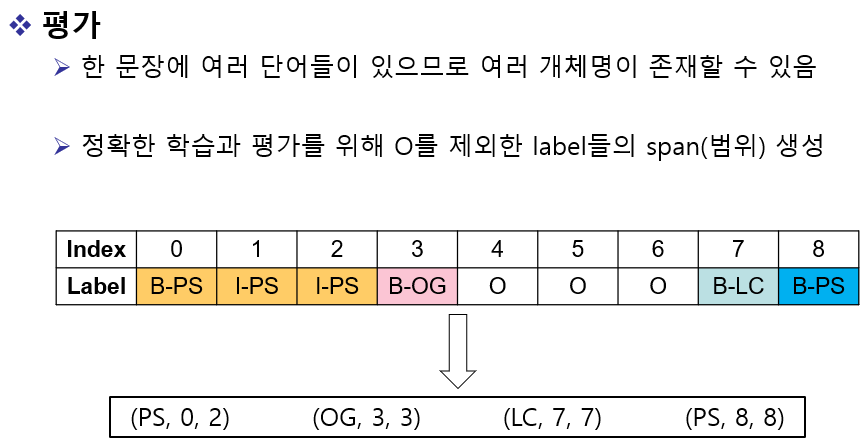

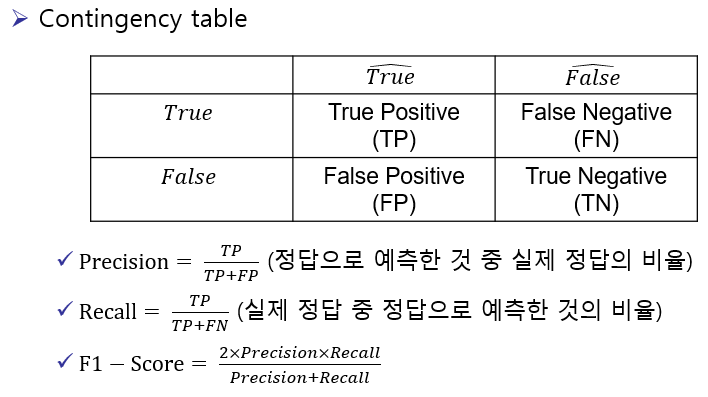

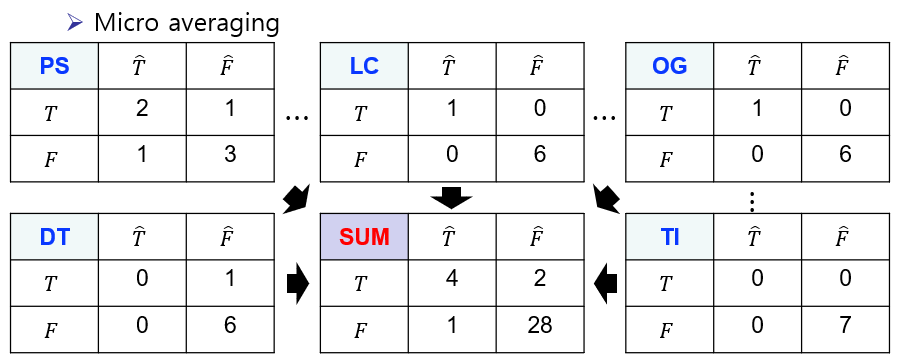

# 성능 평가 함수

In [34]:
from collections import defaultdict

def get_entity_spans(seq):
    if any(isinstance(s, list) for s in seq):
        seq = [item for sublist in seq for item in sublist + ['O']]

    pre_bio = 'O'
    pre_ne_type = ''
    begin_offset = 0
    start_entity = False
    spans = list()

    for i, label in enumerate(seq + ['O']):
        cur_bio = label[0]
        cur_ne_type = label.split('-')[-1]

        if (pre_bio == 'B' and (cur_bio == 'B' or cur_bio == 'O' or (cur_bio == 'I' and cur_ne_type != pre_ne_type))) and start_entity:
            spans.append((pre_ne_type, begin_offset, i-1))
        elif (pre_bio == 'I' and (cur_bio == 'B' or cur_bio == 'O' or (cur_bio == 'I' and cur_ne_type != pre_ne_type))) and start_entity:
            spans.append((pre_ne_type, begin_offset, i-1))

        if cur_bio == 'B':
            begin_offset = i
            start_entity = True

        pre_bio = cur_bio
        pre_ne_type = cur_ne_type

    return spans

In [37]:
def precision_score(y_true, y_pred):
    score = None
    """
    위의 get_entity_spans 함수를 이용해 precision score를 구하시오.
    """

    ne_label = set(get_entity_spans(y_true))
    ne_pred = set(get_entity_spans(y_pred))

    score = len(ne_label & ne_pred) / len(ne_pred) if len(ne_pred) > 0 else 0

    return score

def recall_score(y_true, y_pred):
    score = None
    """
    위의 get_entity_spans 함수를 이용해 precision score를 구하시오.
    """

    ne_label = set(get_entity_spans(y_true))
    ne_pred = set(get_entity_spans(y_pred))

    score = len(ne_label & ne_pred) / len(ne_label) if len(ne_label) > 0 else 0

    return score

def f1_score(p, r):
    score = 2 * p * r / (p + r) if p + r > 0 else 0

    return score

# 성능 평가

In [39]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(precision, recall)

print("Precision score: {:.3f}%".format(precision*100))
print("Recall score: {:.3f}%".format(recall*100))
print("F1 score: {:.3f}%".format(f1*100))

Precision score: 53.550%
Recall score: 54.778%
F1 score: 54.157%


# 사전학습 된 단어 임베딩을 활용한 NER

# 사전학습 된 단어 임베딩 및 단어 사전 로딩

In [40]:
with open('./NER/glove.npy', 'rb') as fin:
    glove = np.load(fin)

glove_tensor = torch.tensor([x for x in glove], dtype=torch.float)
print("The number of pre-trained words: {}".format(len(glove_tensor)))
embedding_dim = glove_tensor.size(1)

token2idx = dict()
with open('./NER/word.dict', 'r') as fin:
    for line in fin.readlines():
        token, idx = line.replace("\n", "").split("\t")
        token2idx[token] = int(idx)
n_tokens = len(token2idx)

The number of pre-trained words: 17831


<ipython-input-40-08d3d25fb7a6>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  glove_tensor = torch.tensor([x for x in glove], dtype=torch.float)


# 입력 텐서 구축

In [41]:
"""
입력 텐서 구축 - 위와 동일
"""
x_train_idx = convert_token_to_idx(x_train, token2idx, max_seq_length)
x_valid_idx = convert_token_to_idx(x_valid, token2idx, max_seq_length)

x_train_tensor = torch.tensor(x_train_idx, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)

x_valid_tensor = torch.tensor(x_valid_idx, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid_idx, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)

# 모델 정의

In [54]:
"""
모델 정의 및 선언 - 위와 동일
"""
class GloveLSTMForNER(nn.Module):
    def __init__(self, pretrained_embedding, embedding_dim, max_seq_length, n_labels):
        super(GloveLSTMForNER, self).__init__()
        """
        nn.Embedding()
        nn.LSTM()
        nn.Linear()
        을 사용하시오.
        """

        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=4,
            batch_first=True,
            bidirectional=True,
        )
        self.out = nn.Linear(embedding_dim * 2, n_labels)


    def forward(self, x_train):
        out = None
        """
        forward 함수를 구축하시오.
        """
        # x_train shape: (B, L)
        embedded_seq = self.embedding(x_train) # shape: (B, L, D)
        last_hidden_state, _ = self.lstm(embedded_seq)
        out = self.out(last_hidden_state)

        return out # shape: (B, L=149, C=31)

# 학습

In [55]:
"""
학습 프로세스 - 위와 동일
"""
from torch.optim import Adam
from tqdm import tqdm

"""
학습 프로세스를 구현하시오.
"""

model = GloveLSTMForNER(glove_tensor, embedding_dim, max_seq_length, n_labels)
model.to(device)

learning_rate = 0.01
n_epochs = 10
train_batch_size = 32
valid_batch_size = 8

criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    drop_last=False,
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=valid_batch_size,
    shuffle=False,
    drop_last=False,
)

min_loss = 9e+16

for epoch in range(n_epochs):
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, position=0, desc=f"{epoch+1} Epoch...")):
        input, label = tuple(b.to(device) for b in batch)

        predict = model(input) # (B, L, C) -> (B * L, C)
        # label shape: (B, L,) -> (B * L, )
        loss = criterion(predict.view(-1, len(label_set)), label.view(-1))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    total_valid_loss = .0
    with torch.no_grad():
        for valid_step, valid_batch in enumerate(valid_dataloader):
            valid_input, valid_label = tuple(b.to(device) for b in batch)

            valid_predict = model(valid_input)
            valid_loss = criterion(valid_predict.view(-1, len(label_set)), valid_label.view(-1))

            total_valid_loss += valid_loss.item()

        if total_valid_loss < min_loss:
            torch.save(model.state_dict(), os.path.join('./model_glove_embed.bin'))
            min_loss = total_valid_loss


10 Epoch...: 100%|██████████| 188/188 [00:01<00:00, 158.98it/s]


# 테스트 및 성능 평가

In [56]:
"""
테스트 및 성능 평가 - 위와 동일
"""
model.load_state_dict(torch.load('./model_glove_embed.bin'))

x_test, y_test = formalize_inputs(test_raw)

x_test_idx = convert_token_to_idx(x_test, token2idx, max_seq_length)
y_test_idx = convert_label_to_idx(y_test, label2idx, max_seq_length)

x_test_tensor = torch.tensor([x for x in x_test_idx], dtype=torch.long)
y_test_tensor = torch.tensor([y for y in y_test_idx], dtype=torch.long)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

test_batch_size = 8
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

all_preds = list()
all_labels = list()

model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_dataloader, position=0, desc="Test..."):
        test_x, test_y = tuple(b.to(device) for b in test_batch)
        test_y_preds = model(test_x)

        predicted_labels = list()
        true_labels = list()
        for pred_idx, true_idx in zip(torch.argmax(test_y_preds, dim=-1)[test_y != -100], test_y[test_y != -100]):
            predicted_labels.append(idx2label[pred_idx.item()])
            true_labels.append(idx2label[true_idx.item()])

        all_preds.append(predicted_labels)
        all_labels.append(true_labels)

Test...: 100%|██████████| 250/250 [00:02<00:00, 107.09it/s]


In [57]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(precision, recall)

print("Precision score: {:.3f}%".format(precision*100))
print("Recall score: {:.3f}%".format(recall*100))
print("F1 score: {:.3f}%".format(f1*100))

Precision score: 61.511%
Recall score: 58.169%
F1 score: 59.793%


# 실습 과제

##RNN, CNN, MLP 등을 이용하여 본 실습에서 구축한 모델의 성능보다 좋은 성능을 보여주는 모델을 구축하시오.

##제출: bonggeun.choi818@gmail.com
##제출물: .ipynb 파일